In [1]:
import pandas as pd
import numpy as np
import datetime
import random
import seaborn as sns
import math
import gc
import time
import pickle
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import warnings
warnings.filterwarnings('ignore')
from sklearn import preprocessing
import xgboost as xgb
from sklearn.model_selection import train_test_split
import copy
import multiprocessing
from sklearn.metrics import roc_auc_score
from operator import itemgetter

from jupyterthemes import jtplot
jtplot.style(theme='oceans16')
jtplot.style(context='talk', fscale=1.5, spines=False, gridlines='')

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'w'
pd.options.display.max_columns = None
pd.options.display.max_rows = 100

# Project Background

## Dataset

The dataset consists of feature vectors belonging to 12,330 sessions. 
The dataset was formed so that each session 
would belong to a different user in a 1-year period to avoid 
any tendency to a specific campaign, special day, user 
profile, or period.

In [2]:
predictors=[]

In [3]:
root_wd = '/Users/zakkyang/Documents/Data_Mining/Python/Projects/0_My_Project/Online_Shopper_Prediction/'
data = pd.read_csv(root_wd+'/Dataset/online_shoppers_intention.csv')
data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


## Feature Descriptions

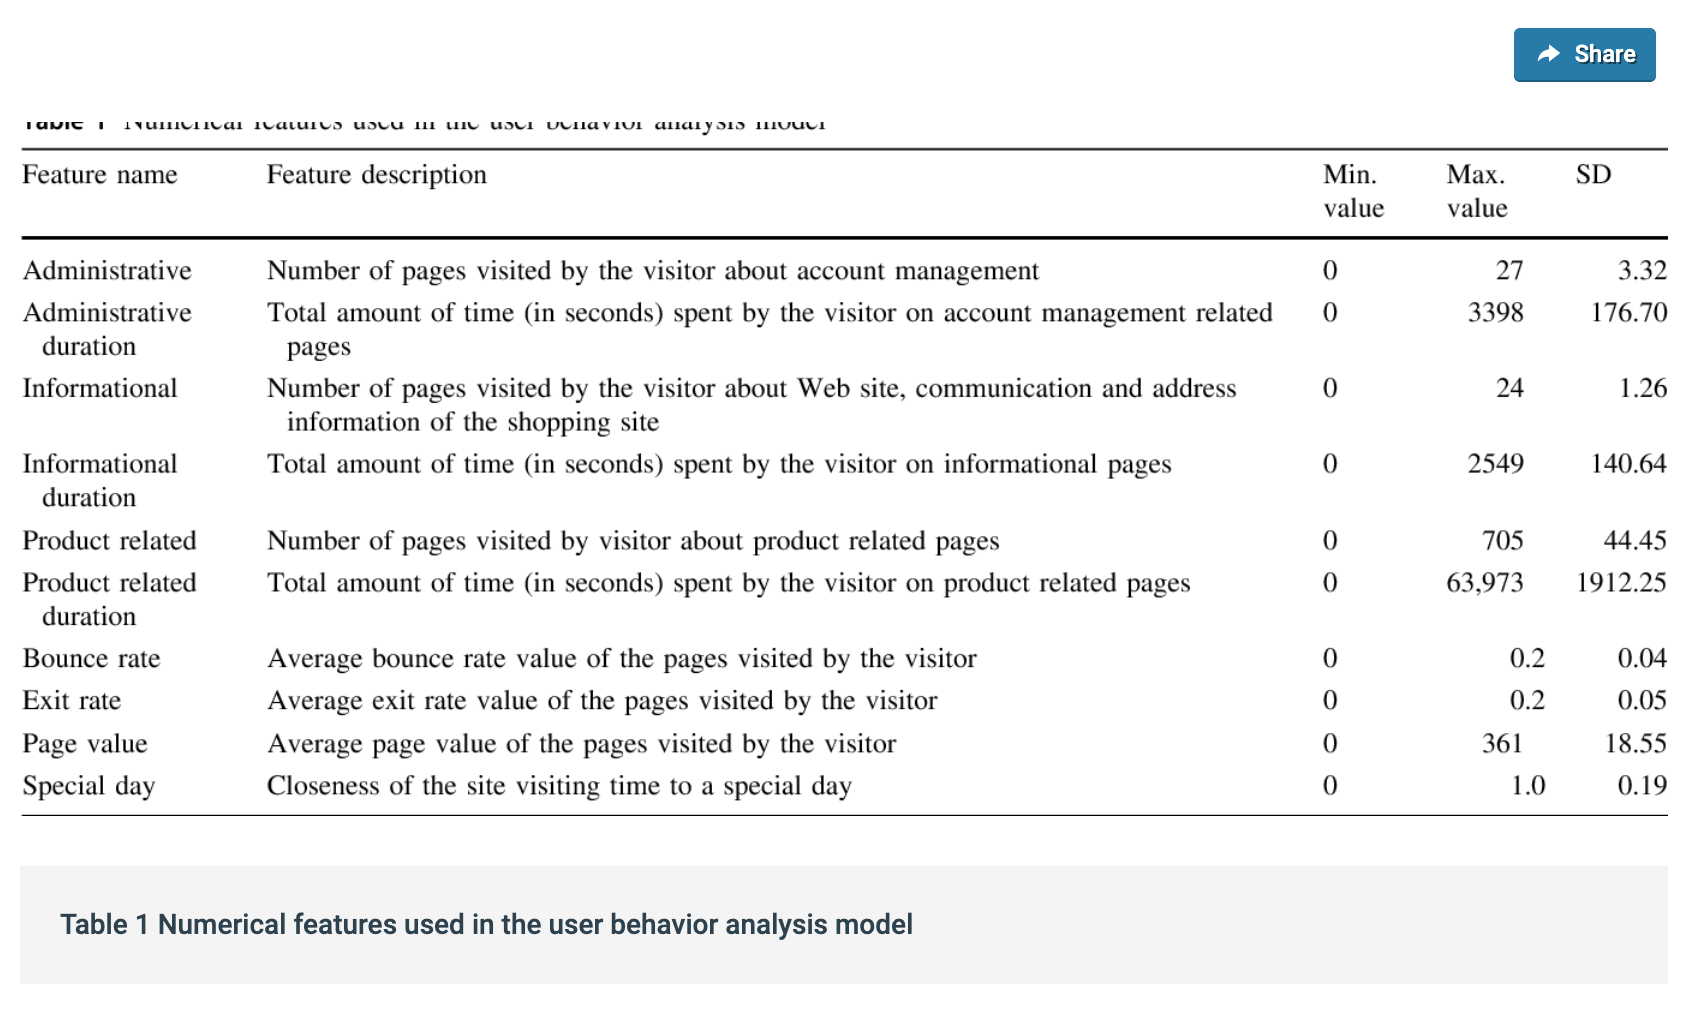

In [4]:
from IPython.display import Image
Image(filename='/Users/zakkyang/Documents/Data_Mining/Python/Projects/0_My_Project/Online_Shopper_Prediction/Pics/1.png')

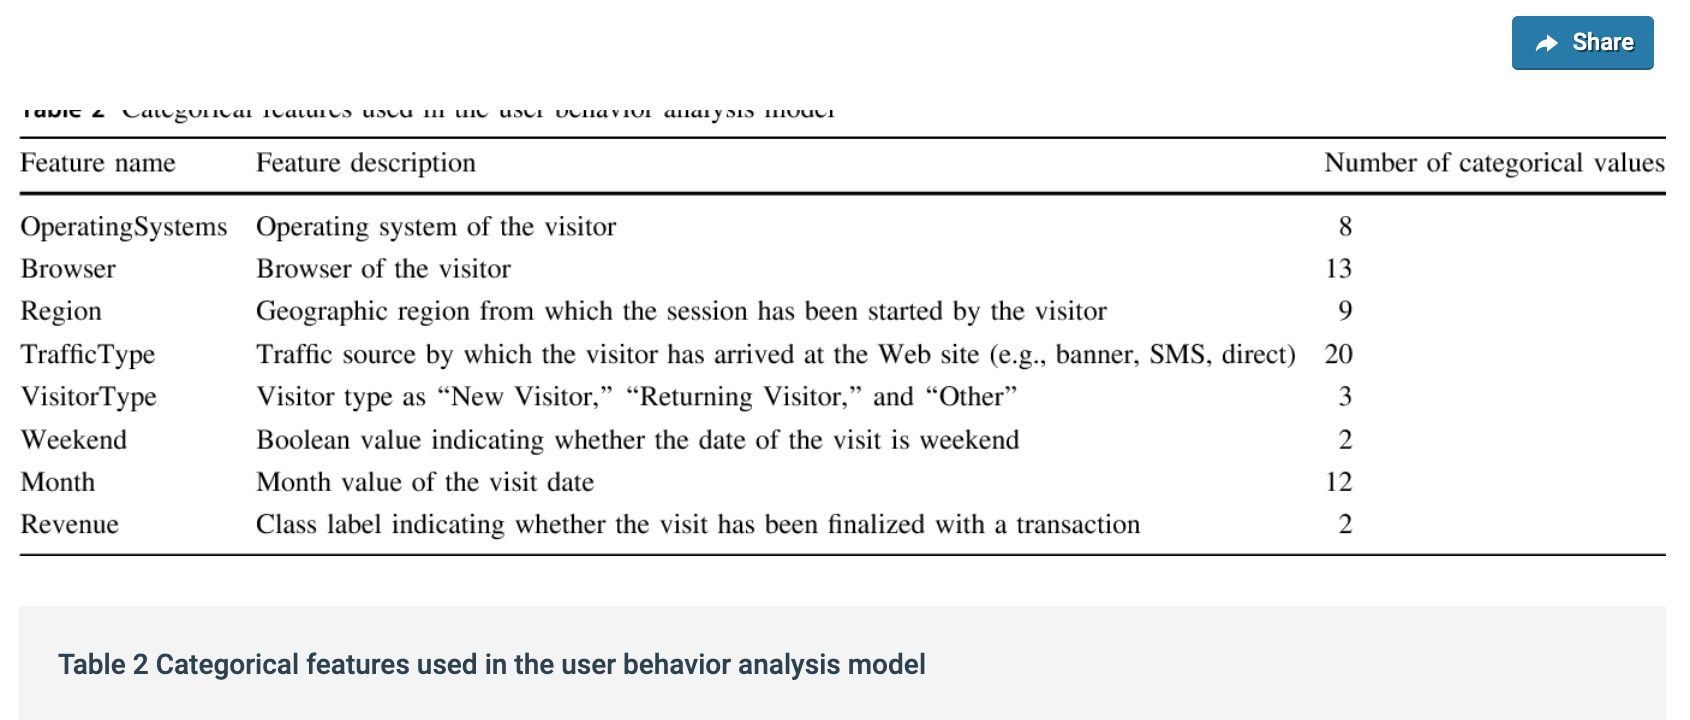

In [5]:
Image(filename='/Users/zakkyang/Documents/Data_Mining/Python/Projects/0_My_Project/Online_Shopper_Prediction/Pics/2.png')

## Define Helper Functions

In [6]:
#define time log function
def log(info):
    print (time.strftime('%Y-%m-%d %H:%M:%S', time.localtime()) + ' ' + str(info))

# Preprocess the Data

## Transform the Datatype

In [7]:
data.dtypes

Administrative               int64
Administrative_Duration    float64
Informational                int64
Informational_Duration     float64
ProductRelated               int64
ProductRelated_Duration    float64
BounceRates                float64
ExitRates                  float64
PageValues                 float64
SpecialDay                 float64
Month                       object
OperatingSystems             int64
Browser                      int64
Region                       int64
TrafficType                  int64
VisitorType                 object
Weekend                       bool
Revenue                       bool
dtype: object

In [8]:
cat_col = ['Browser', 'OperatingSystems', 'Region', 'TrafficType', 'VisitorType']
for f in cat_col:
    data[f]=data[f].astype('category')

In [9]:
data['Weekend'] = data['Weekend'].apply(lambda x: 1 if x== True else 0)
data['Revenue'] = data['Revenue'].apply(lambda x: 1 if x== True else 0)

## Rename the Columns

In [10]:
data.rename(columns={'Administrative': 'account_view_pages',
                    'Administrative_Duration': 'account_view_duration',
                    'Informational': 'info_view_pages',
                    'Informational_Duration': 'info_view_duration'}, inplace=True)

In [11]:
log('Data Preprocessing Finished')

2019-05-19 15:04:41 Data Preprocessing Finished


In [12]:
data.dtypes

account_view_pages            int64
account_view_duration       float64
info_view_pages               int64
info_view_duration          float64
ProductRelated                int64
ProductRelated_Duration     float64
BounceRates                 float64
ExitRates                   float64
PageValues                  float64
SpecialDay                  float64
Month                        object
OperatingSystems           category
Browser                    category
Region                     category
TrafficType                category
VisitorType                category
Weekend                       int64
Revenue                       int64
dtype: object

# EDA

## Define EDA Functions

In [13]:
#quick EDA to numeric columns
def number_col_hist(data, target, target_var1,target_var2):
    for col in list(data.select_dtypes('number').columns):
        plt.figure(figsize=(15,2))
        data[data[target] == target_var1][col].hist(label='Not Buy', bins=20, alpha=0.4, color='red')
        data[data[target] == target_var2][col].hist(label='Buy', bins=20, alpha=0.4, color = 'green')
        plt.xlabel(col, size=10), plt.ylabel('Frequency', size=10), plt.title(col)
        plt.legend(loc=0)

        
#density chart of numeric columns to look into the distribution of the target
def number_col_kde(data, target, target_var1,target_var2):
    for col in list(data.select_dtypes('number').columns):
        plt.figure(figsize=(15,2))
        sns.kdeplot(data[data[target] == target_var1][col], label='Not Buy', color='red',alpha=0.8)
        sns.kdeplot(data[data[target] == target_var2][col], label='Buy', color='green', alpha=0.8)
        plt.ylabel('Density'), plt.title(col)

    
#define a facet grid for line type
def facetgrid_line (x,y,col,row,hue,df):
    g = sns.FacetGrid(
    df,
    row=row,
    col = col,
    hue=hue,
    palette="Set1",
    aspect=1.5,
    size=5,
    sharex=False)
    g = g.map(sns.lineplot, x, y, ci=None).add_legend()
    
    #define a facet grid for bar type
def facetgrid_bar (x,y,col,row,hue,df):
    g = sns.FacetGrid(
    df,
    row=row,
    col = col,
    hue=hue,
    palette="Set1",
    aspect=1.5,
    size=5,
    sharex=False)
    g = g.map(sns.barplot, x, y, ci=None).add_legend()

#univariate analysis
def univar_percent(data, target):
    for col in list(data.select_dtypes(exclude='number').columns):
        g=data.groupby([col,target]).size().reset_index(name='Counts')
        a=g.groupby(col)['Counts'].transform('sum')
        g['Counts_Percentage'] = g['Counts'].div(a)
        sns.barplot(data=g, y=col, x='Counts_Percentage', hue= target,orient='h')
        plt.figure(figsize=(15,4))

## Start EDA

In [14]:
print('Target Ratio= {:.2%}'.format (data['Revenue'].value_counts()[1]/data.shape[0]))

Target Ratio= 15.47%


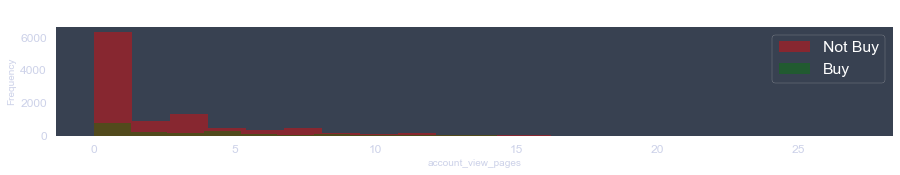

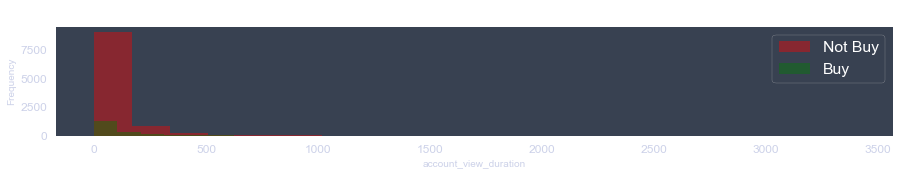

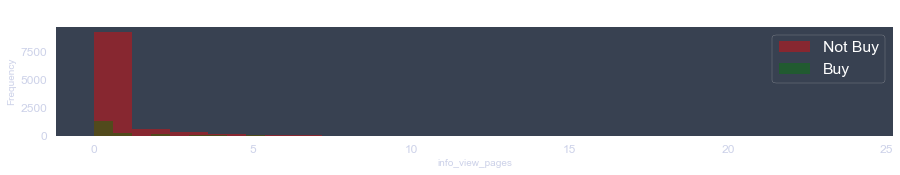

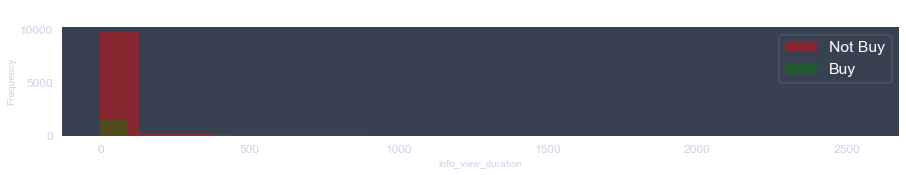

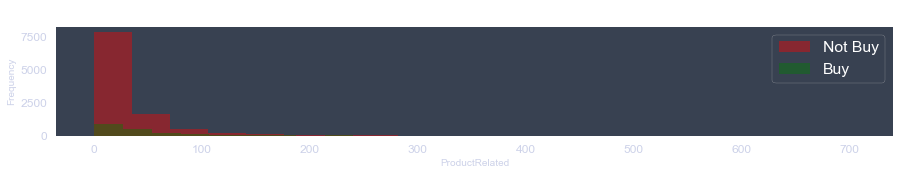

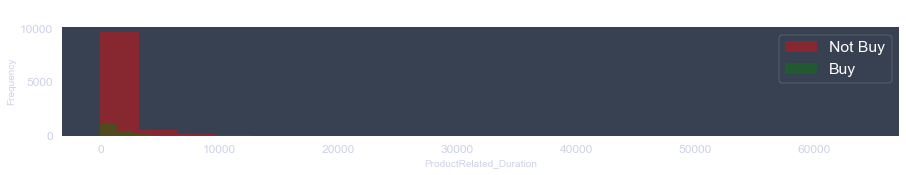

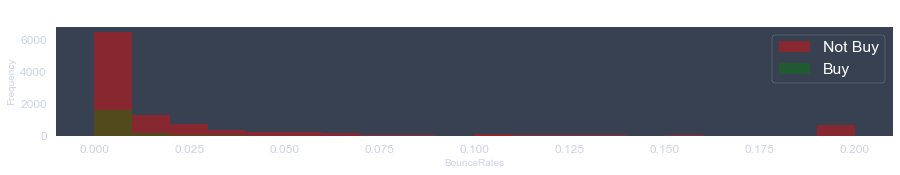

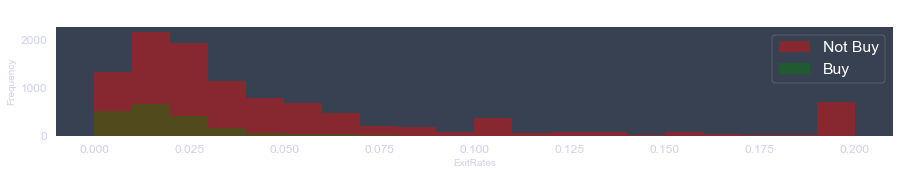

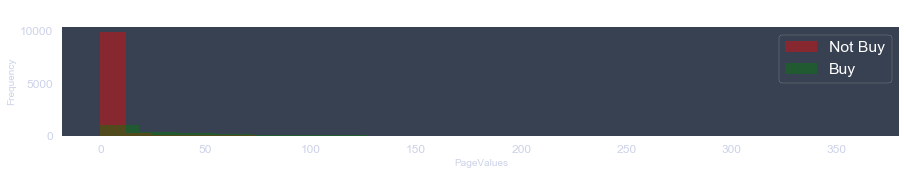

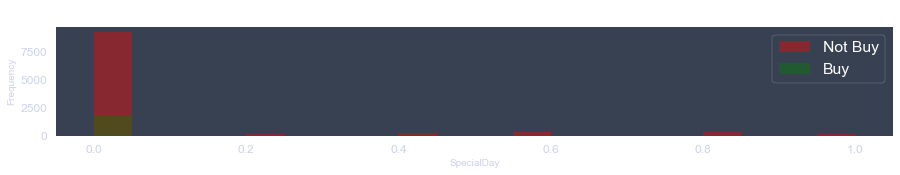

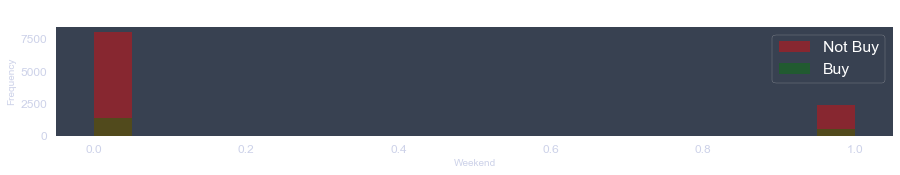

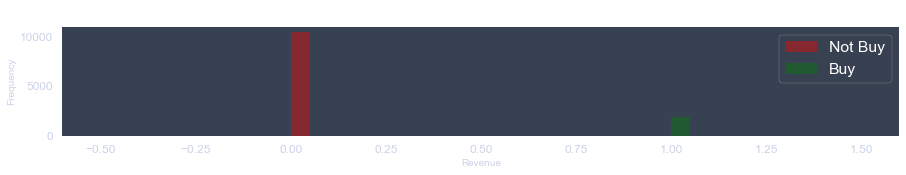

In [15]:
number_col_hist(data, 'Revenue',0,1)

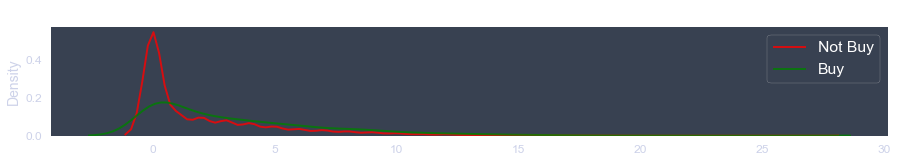

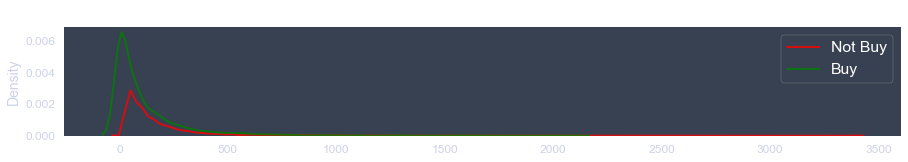

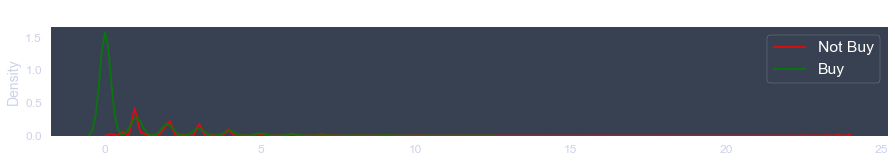

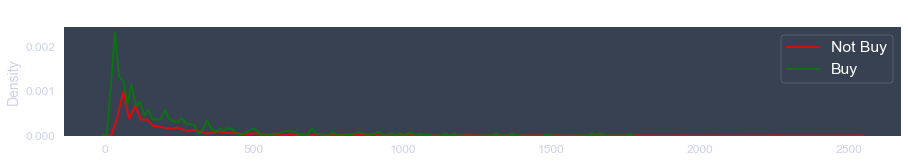

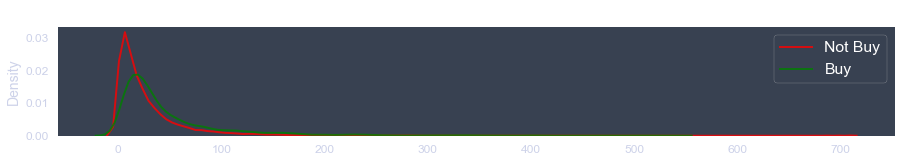

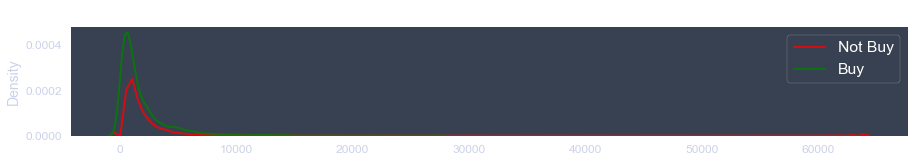

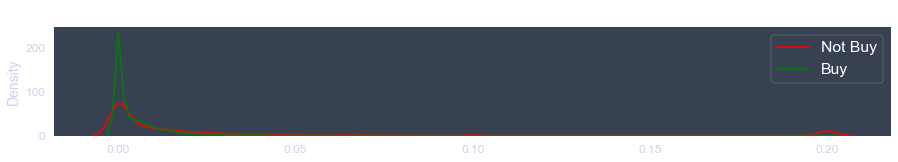

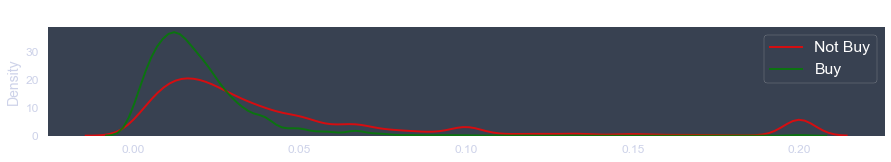

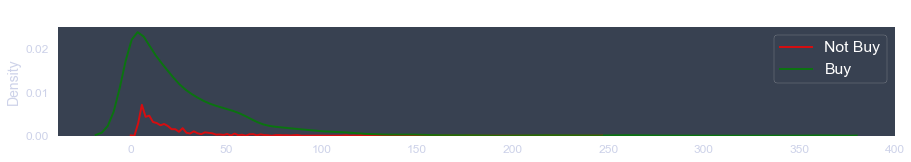

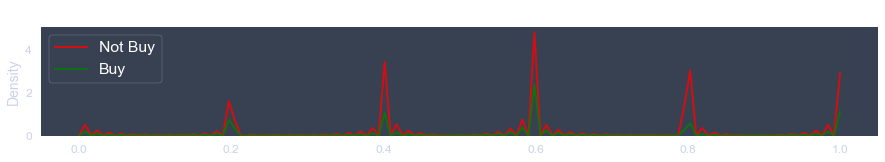

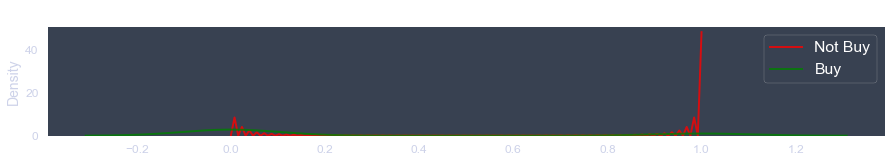

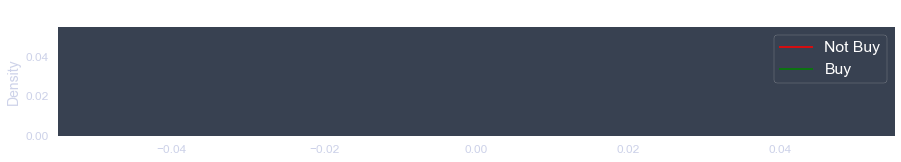

In [16]:
number_col_kde(data, 'Revenue',0,1)

- Number of account view pages/duration: succesful buyers will spend less time in viewing account info. Why?
- Information pages: it is interesting to find that those who successfully buy things will not spend time browsing around, does this imply that they are already familia with the website?
- Product related pages: it is natural for buyers to spend time viewing products
- Bounce Rate: Google’s own definition of bounce rate is: “The percentage of single-page sessions” (i.e. sessions in which the person left your site from the entrance page without interacting with the page). It is surprising to see that both buyer and no-buyers have a low bounce rate, indicating that they will at least stay for a while.
- Exit Rate: Exit rate, on the other hand, looks at the number of people who exit your website after landing on a page and compares it to the total number of views the page received. https://conversionxl.com/guides/bounce-rate/bounce-rate-vs-exit-rate/
- Page Value: Despite the fact that succesful buyers will view more high-value pages, but the difference is not so distintive between customers and non-customers
- Special Day: it does influence the shoppers in buying intention
- Weekend: no specific influence

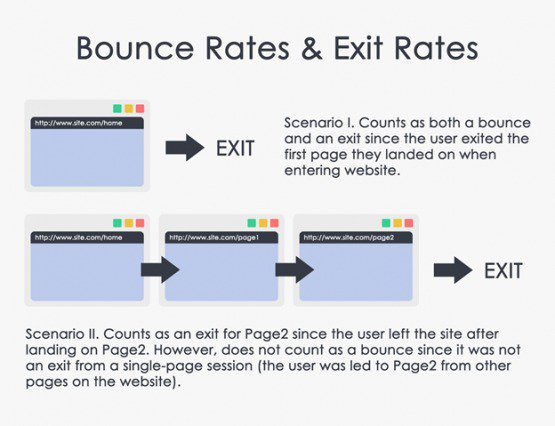

In [17]:
Image(filename='/Users/zakkyang/Documents/Data_Mining/Python/Projects/0_My_Project/Online_Shopper_Prediction/Pics/bounce+exit.jpg')

In [18]:
#check out the unique values of categorical columns
for col in cat_col:
    unique=data[col].nunique()
    print("Feature '{col}' has {unique} unique features".format(col=col, unique=unique))

Feature 'Browser' has 13 unique features
Feature 'OperatingSystems' has 8 unique features
Feature 'Region' has 9 unique features
Feature 'TrafficType' has 20 unique features
Feature 'VisitorType' has 3 unique features


In [19]:
a =data.groupby(['Month','VisitorType', 'OperatingSystems', 'Region' ,'Revenue']).size().reset_index(name='count')

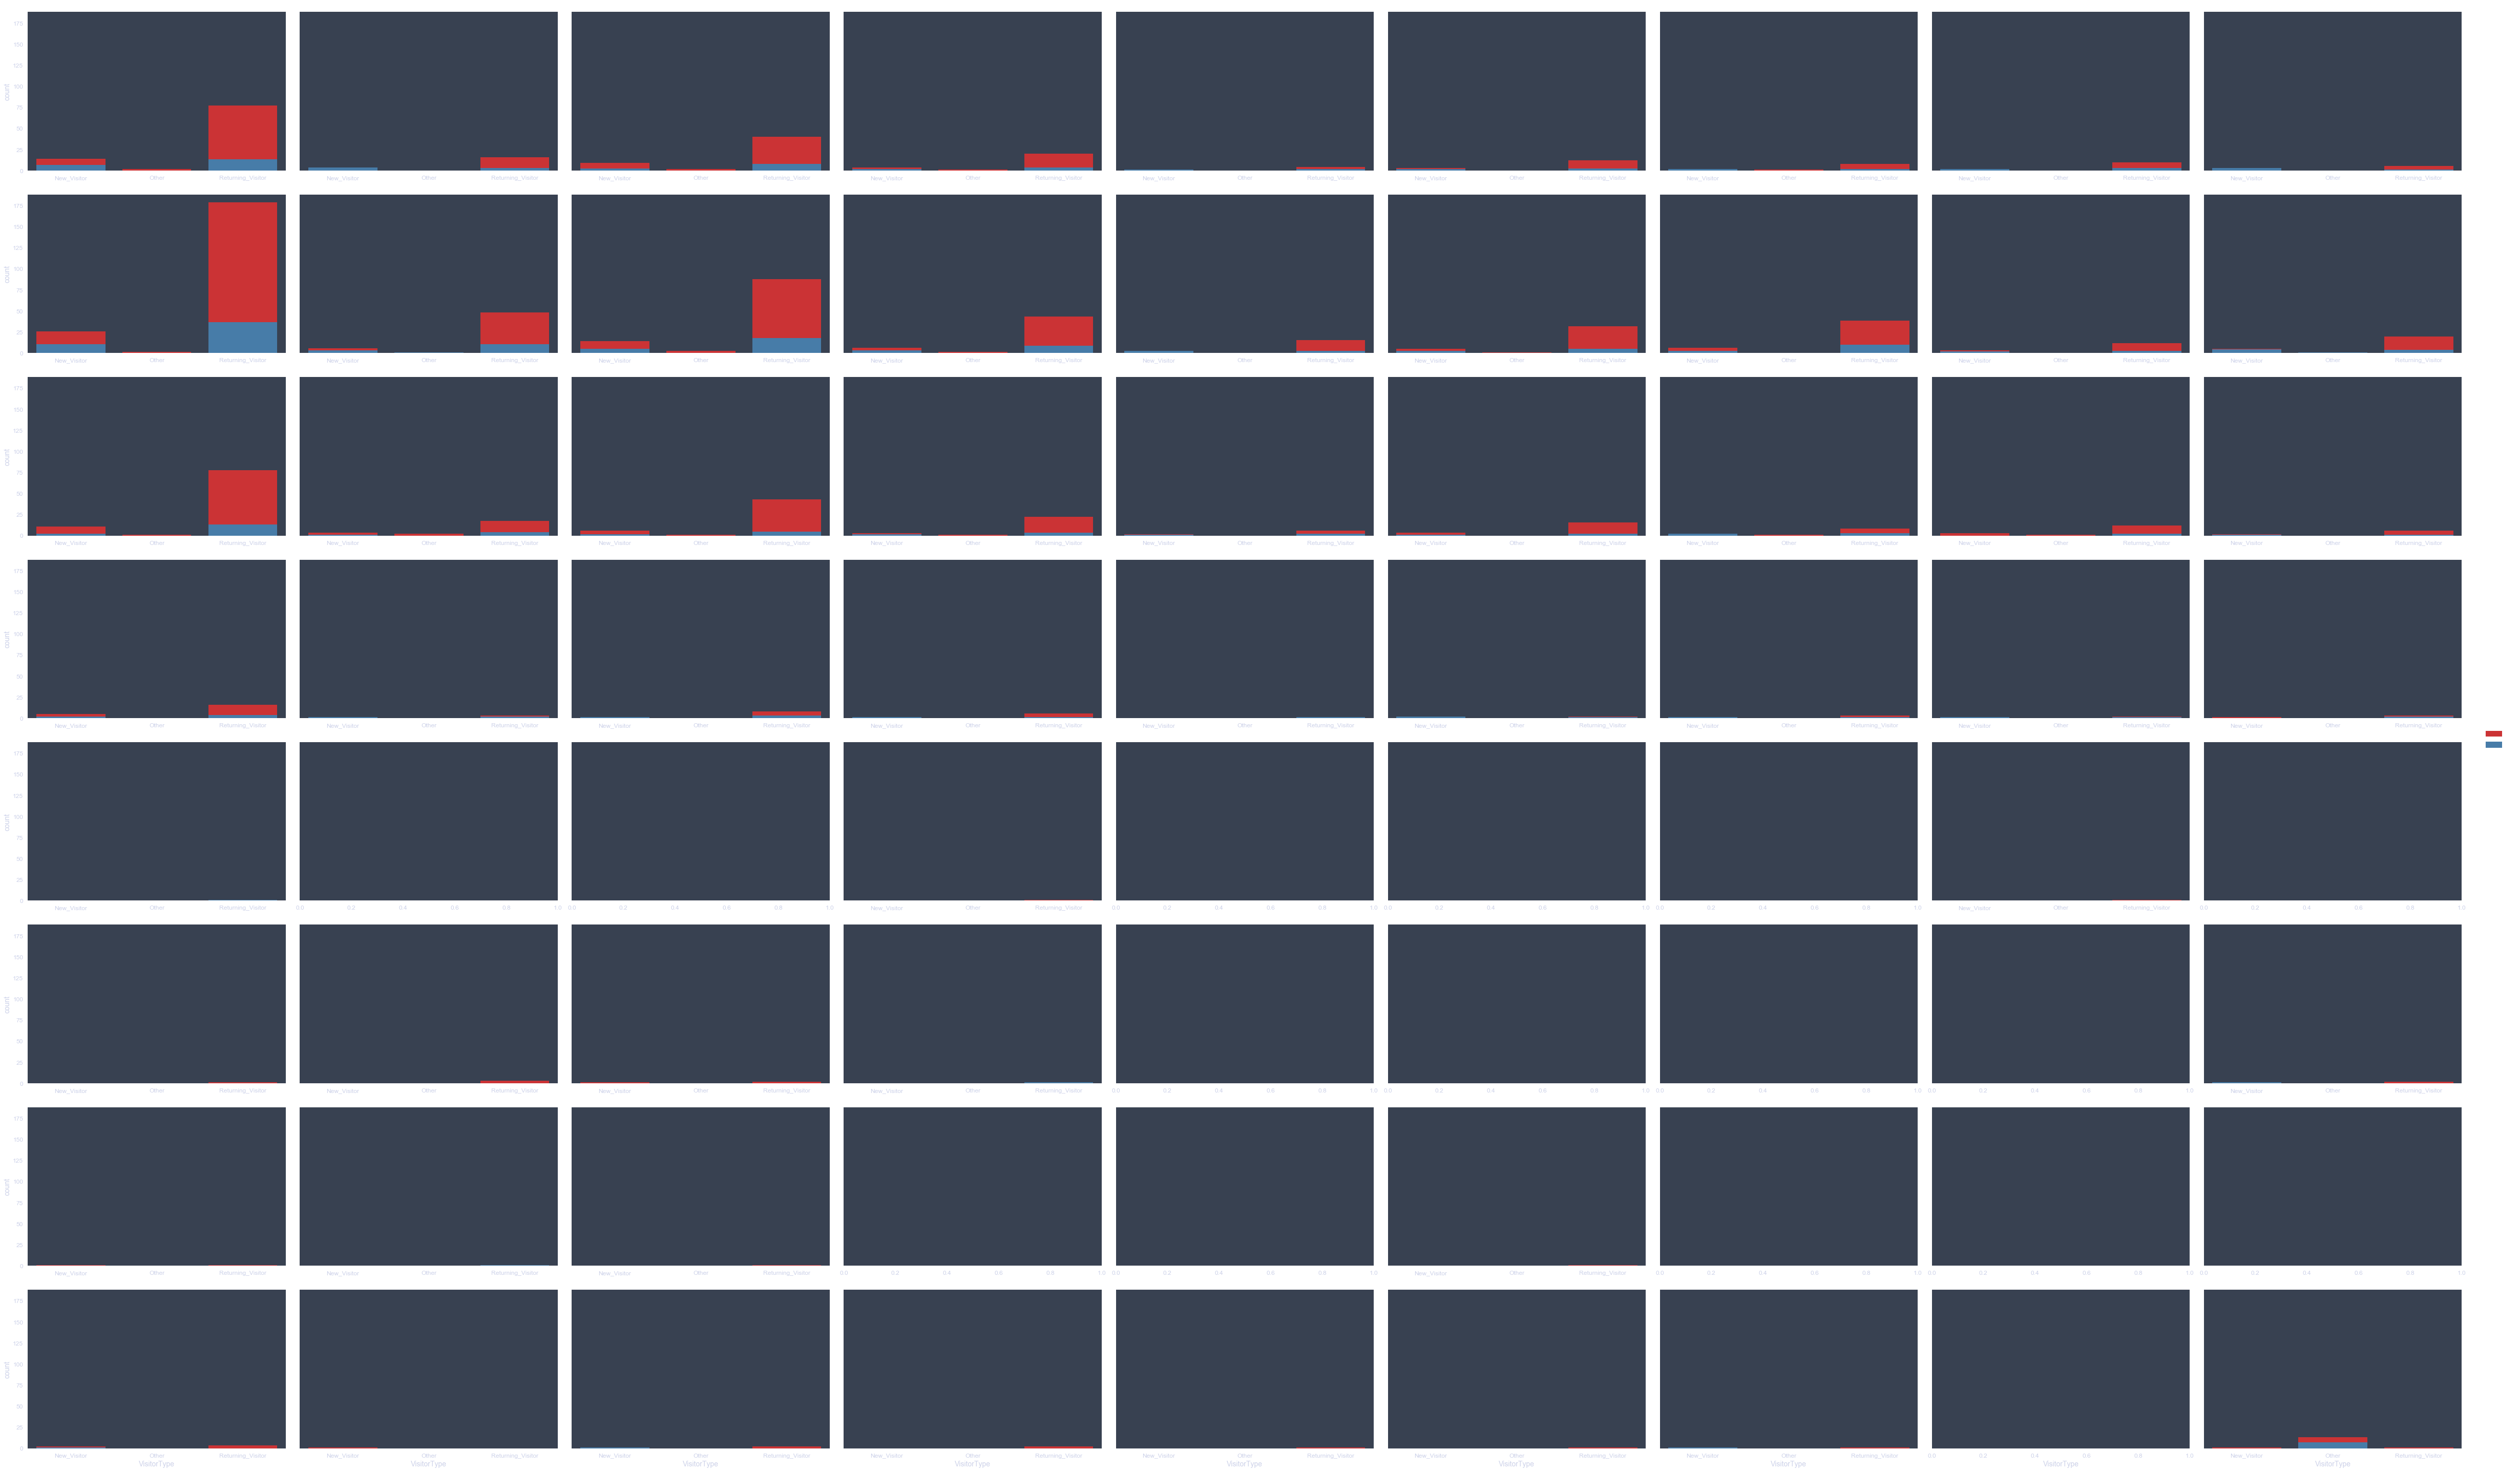

In [20]:
facetgrid_bar('VisitorType', 'count','Region', 'OperatingSystems', 'Revenue', df=a)

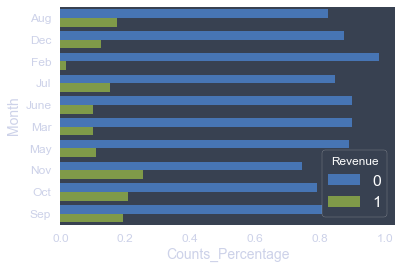

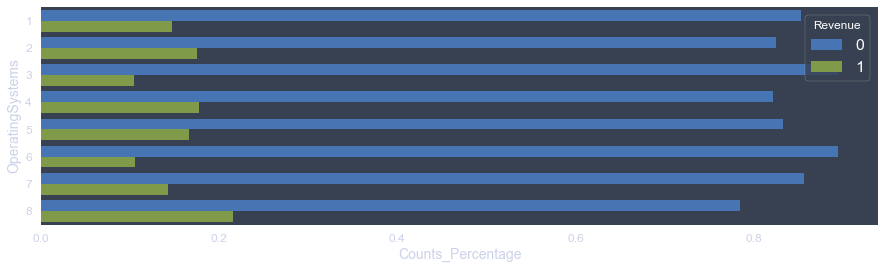

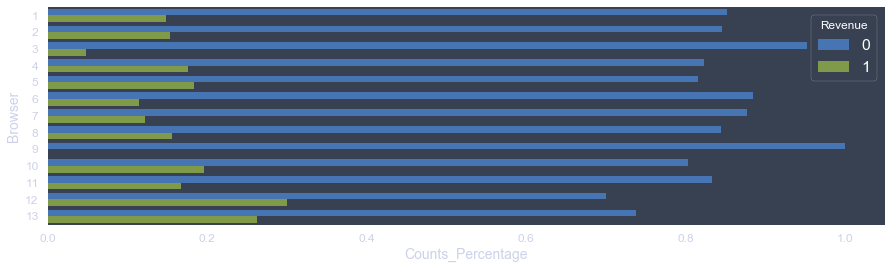

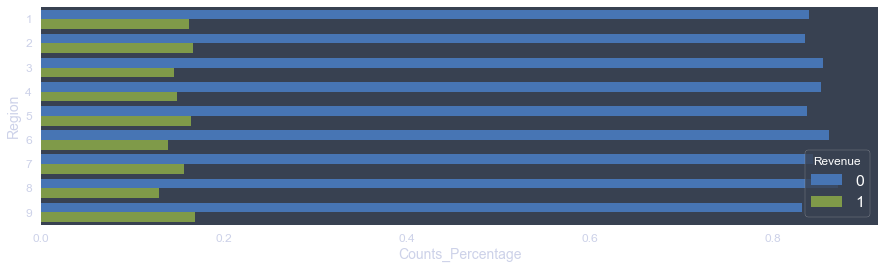

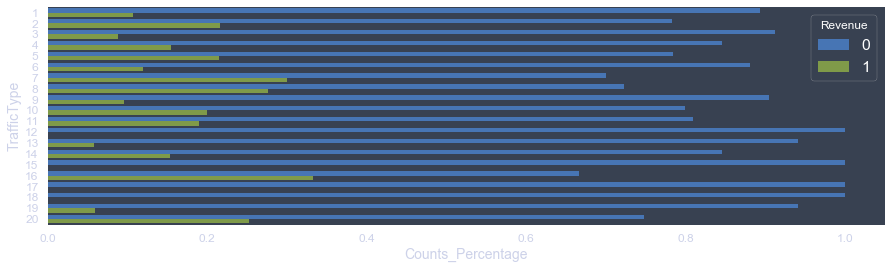

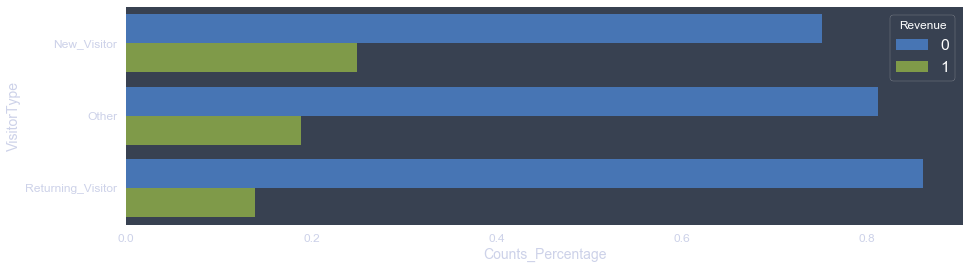

<Figure size 1080x288 with 0 Axes>

In [21]:
univar_percent(data, 'Revenue')

## Correlation

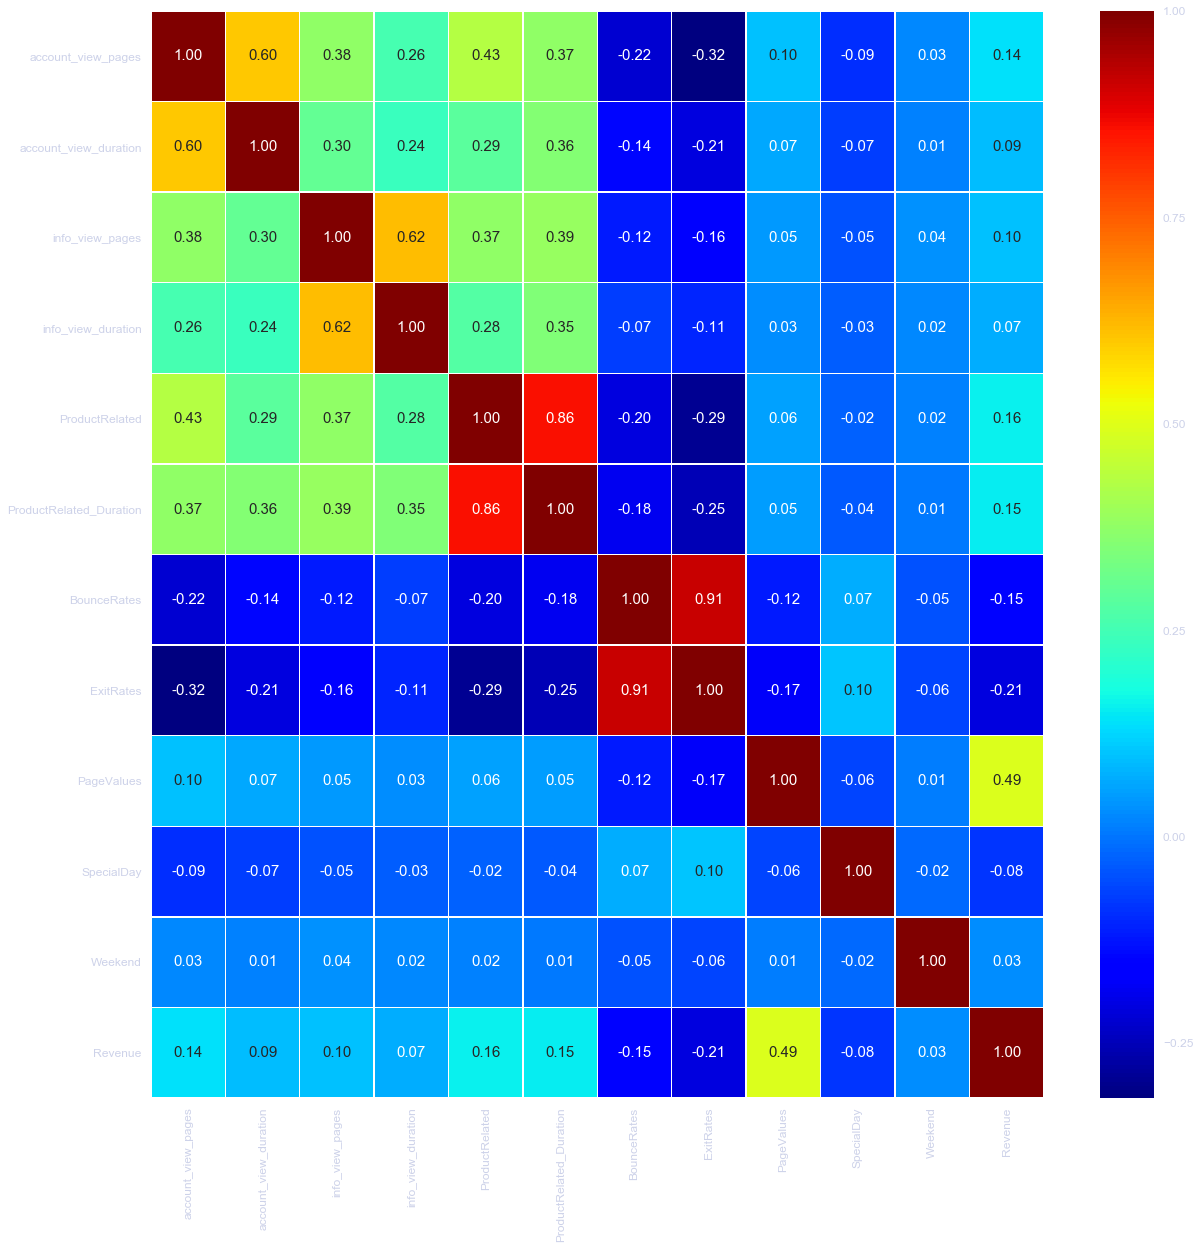

In [22]:
#compare with the orignal data
corrmat_origin = data.corr()
cmap = plt.get_cmap("jet")
plt.figure(figsize=(20,20))
sns.heatmap(
    corrmat_origin,
    annot=True,
    fmt='.2f',
    linewidths=.5,
    cmap=cmap,
    annot_kws={'size': 15})


# Save

In [30]:
pickle.dump(data, open(root_wd + '/Pickle/all.p', 'wb'))